# Проект "Выбор локации для скважины"

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

Импорты библиотек

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

from sklearn.metrics import mean_squared_error
import numpy as np

import matplotlib.pyplot as plt

!pip install phik;
from phik import phik_matrix
import warnings
warnings.filterwarnings('ignore')

___Цель работы___:
* Предсказать запасы по данным из трёх регионов
* Посчитать возможную прибыль и риски в каждом из регионов и выбрать наиболе перспективный
___Задачи проекта___:
* Загрузить данные
* Подготовить данные для применения моделей машинного обучения
* Использование модели линейной регресии для предсказания запасов
* Подготовка к расчёту прибыли
* Предсказание возможной прибыли и рисков убытков

___Общий вывод___

## Загрузка и подготовка данных

### Загрузка и вывод данных

In [2]:
geo_data_0 = pd.read_csv('/datasets/geo_data_0.csv')
geo_data_1 = pd.read_csv('/datasets/geo_data_1.csv')
geo_data_2 = pd.read_csv('/datasets/geo_data_2.csv')

In [3]:
geo_data_0.head()

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


In [4]:
geo_data_1.head()

,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


In [5]:
geo_data_2.head()

,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


### Информация о данных и проверка на пропуски

In [6]:
geo_data_0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [7]:
geo_data_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [8]:
geo_data_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


Пропусков не обнаружено. Изначальные типы данных подходят для дальнейшей работы.

### Поиск дубликатов

Поиск дубликатов по id

In [9]:
dup_0 = geo_data_0.duplicated(subset=['id']).sum()
dup_0

10

In [10]:
dup_1 = geo_data_1.duplicated(subset=['id']).sum()
dup_1

4

In [11]:
dup_2 = geo_data_2.duplicated(subset=['id']).sum()
dup_2

4

In [12]:
geo_data_0.drop_duplicates(subset=['id'],inplace=True)
geo_data_1.drop_duplicates(subset=['id'],inplace=True)
geo_data_2.drop_duplicates(subset=['id'],inplace=True)

___Вывод по исзодным данным и преобработке___: Изначально данные были практически готовы для использования моделей машинного обучения. Были удалены дубликаты по столбцу id в рамках подготовки данных

### Корреляция признаков 

In [15]:
geo_data_0_phik = geo_data_0
geo_data_0_phik.phik_matrix().style.background_gradient(cmap='coolwarm')

interval columns not set, guessing: ['f0', 'f1', 'f2', 'product']


,id,f0,f1,f2,product
id,1.000000,1.000000,1.000000,1.000000,1.000000
f0,1.000000,1.000000,0.762181,0.000000,0.215523
f1,1.000000,0.762181,1.000000,0.000000,0.253534
f2,1.000000,0.000000,0.000000,1.000000,0.475867
product,1.000000,0.215523,0.253534,0.475867,1.000000


In [16]:
geo_data_1_phik = geo_data_1
geo_data_1_phik.phik_matrix().style.background_gradient(cmap='coolwarm')

interval columns not set, guessing: ['f0', 'f1', 'f2', 'product']


,id,f0,f1,f2,product
id,1.000000,1.000000,1.000000,1.000000,1.000000
f0,1.000000,1.000000,0.196075,0.000000,0.628477
f1,1.000000,0.196075,1.000000,0.000000,0.185948
f2,1.000000,0.000000,0.000000,1.000000,0.978935
product,1.000000,0.628477,0.185948,0.978935,1.000000


In [17]:
geo_data_2_phik = geo_data_2
geo_data_2_phik.phik_matrix().style.background_gradient(cmap='coolwarm')

interval columns not set, guessing: ['f0', 'f1', 'f2', 'product']


,id,f0,f1,f2,product
id,1.000000,1.000000,1.000000,1.000000,1.000000
f0,1.000000,1.000000,0.000000,0.000000,0.201070
f1,1.000000,0.000000,1.000000,0.000000,0.220992
f2,1.000000,0.000000,0.000000,1.000000,0.443282
product,1.000000,0.201070,0.220992,0.443282,1.000000


___Вывод о корреляционном анализе___: В таблицах выше можно усмортеть корреляцию между входными признаками. Тем не менее в дальнейшем обучении мы должны использлвать все признаки из имеющихся.

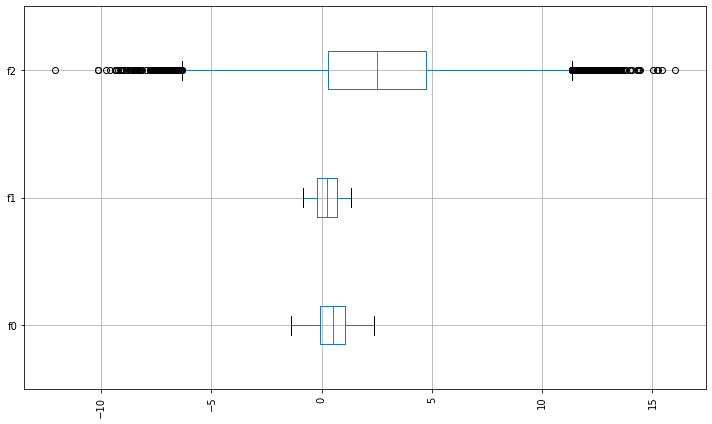

In [18]:
selected_columns = ['f0', 'f1', 'f2']

plt.figure(figsize=(10, 6))  
geo_data_0[selected_columns].boxplot(vert=False)  
plt.xticks(rotation=90) 
plt.tight_layout() 
plt.show()  

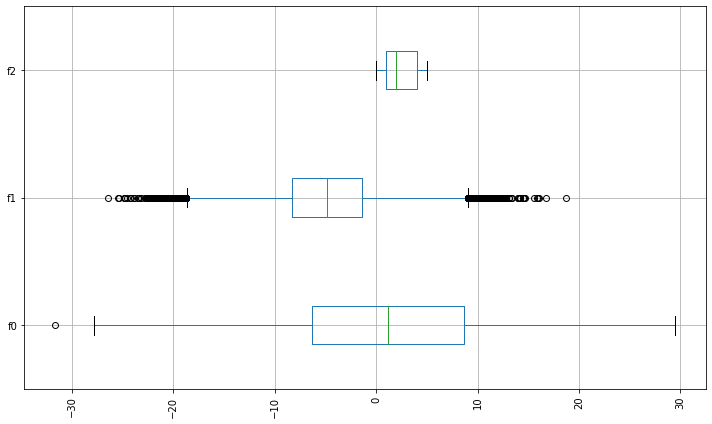

In [19]:
plt.figure(figsize=(10, 6))  
geo_data_1[selected_columns].boxplot(vert=False)  
plt.xticks(rotation=90) 
plt.tight_layout() 
plt.show()  

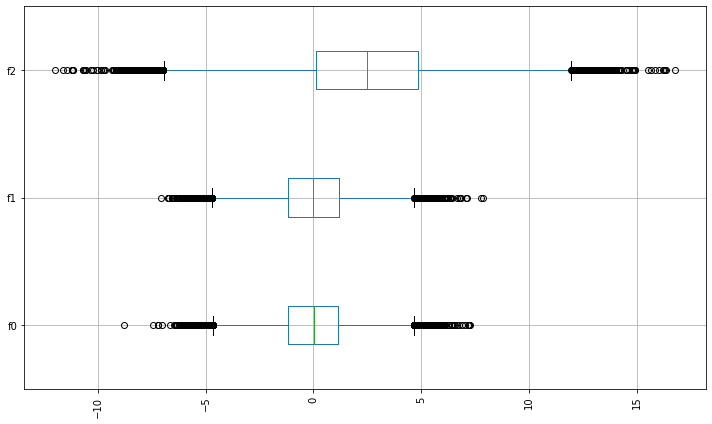

In [20]:
plt.figure(figsize=(10, 6))  
geo_data_2[selected_columns].boxplot(vert=False)  
plt.xticks(rotation=90) 
plt.tight_layout() 
plt.show()  

___Замечание по диаграмам размаха данных___: Примечательно, что выбросы в разных датасетах имеют разный характер. Здесь наверное кроется различие этих регионов.

## Обучение и проверка модели

### Первый регион

In [21]:
RANDOM_STATE = 78
TEST_SIZE = 0.25

train0_data = geo_data_0.drop(columns=['id','product'])
val0_data = geo_data_0['product']
X0_train, X0_val, y0_train, y0_val = train_test_split(train0_data,val0_data, test_size=TEST_SIZE, random_state=RANDOM_STATE)


In [22]:
model0 = LinearRegression()
model0.fit(X0_train, y0_train)

LinearRegression()

In [23]:
y0_val_pred = model0.predict(X0_val)

In [24]:
rmse_0 = np.sqrt(mean_squared_error(y0_val, y0_val_pred))
print(f'RMSE на валидационной выборке первого региона: {rmse_0}')

RMSE на валидационной выборке первого региона: 37.65675849821365


In [25]:
y0_val_df = y0_val.to_frame()

In [26]:
y0_val_df['predict_product'] = y0_val_pred

In [27]:
y0_val_df

,product,predict_product
90958,25.392967,62.739871
47745,129.181041,100.500418
52089,185.164292,108.176557
86725,144.217666,118.953082
70807,24.155853,96.582534
...,...,...
98325,28.738095,77.041451
92661,131.757453,114.165929
85096,121.238879,125.489041
39830,65.986891,99.093966


### Второй и третий регионы

Разделение двух остальных датасетов на тренировочные и валидационные выборки

In [28]:
train1_data = geo_data_1.drop(columns=['id','product'])
val1_data = geo_data_1['product']
X1_train, X1_val, y1_train, y1_val = train_test_split(train1_data,val1_data, test_size=TEST_SIZE, random_state=RANDOM_STATE)

train2_data = geo_data_2.drop(columns=['id','product'])
val2_data = geo_data_2['product']
X2_train, X2_val, y2_train, y2_val = train_test_split(train2_data,val2_data, test_size=TEST_SIZE, random_state=RANDOM_STATE)


In [29]:
model1 = LinearRegression()
model1.fit(X1_train, y1_train)

model2 = LinearRegression()
model2.fit(X2_train, y2_train)

LinearRegression()

In [30]:
y1_val_pred = model1.predict(X1_val)
y2_val_pred = model2.predict(X2_val)

In [31]:
y1_val_df = y1_val.to_frame()
y2_val_df = y2_val.to_frame()

y1_val_df['predict_product'] = y1_val_pred
y2_val_df['predict_product'] = y2_val_pred

In [32]:
rmse_1 = np.sqrt(mean_squared_error(y1_val, y1_val_pred))
print(f'RMSE на валидационной выборке второго региона: {rmse_1}')

RMSE на валидационной выборке второго региона: 0.8887905369651199


In [33]:
rmse_2 = np.sqrt(mean_squared_error(y2_val, y2_val_pred))
print(f'RMSE на валидационной выборке третьего региона: {rmse_2}')

RMSE на валидационной выборке третьего региона: 40.12954545531487


In [34]:
y1_val_df.head(10)

,product,predict_product
52998,3.179103,3.123287
86071,57.085625,57.113016
95170,0.000000,0.673499
32770,134.766305,136.996646
38412,84.038886,83.278436
2289,26.953261,26.459506
77488,137.945408,137.578894
27926,84.038886,83.788916
79952,134.766305,133.530453
93837,107.813044,108.059789


In [35]:
y2_val_df.head(10)

,product,predict_product
52999,29.265796,82.500146
86070,113.281236,80.981803
95170,48.250800,90.437159
32770,46.902034,91.126468
38412,12.130536,87.835015
2289,112.106846,83.683249
77490,124.580725,110.432334
27926,39.646613,106.098178
79954,132.178492,103.575589
93836,128.769468,72.238277


### Средний запас предсказанного сырья

In [36]:
mean_pred_product0 = y0_val_df['predict_product'].mean()
mean_pred_product1 = y1_val_df['predict_product'].mean()
mean_pred_product2 = y2_val_df['predict_product'].mean()

print(f'Средний предсказанный запас первого региона :{round(mean_pred_product0,2)}')
print(f'Средний предсказанный запас второго региона :{round(mean_pred_product1,2)}')
print(f'Средний предсказанный запас третьего региона :{round(mean_pred_product2,2)}')

Средний предсказанный запас первого региона :92.58
Средний предсказанный запас второго региона :68.45
Средний предсказанный запас третьего региона :95.12


___Вывод___: Максимальный средний запас предсказывается в третьем регионе. При этом минимальное RMSE зафиксировано во втором регионе.

## Подготовка к расчёту прибыли

### Переменные  для расчётов

In [37]:
Budget = 10000000000
Price_per_barrel = 450
Income_per_unit = 450000
Wells = 200
All_wells = 500



In [38]:
Well_cost = Budget / Wells 
Well_cost

50000000.0

In [39]:
Required_volume= Well_cost / Income_per_unit
Required_volume

111.11111111111111

___Вывод___: Необходимый объём превышает среднее значения предсказанной добычи во всех регионах

## Расчёт прибыли и рисков 

### Функция для расчёта прибыли

In [40]:
def revenue(target, probabilities):
    target = target.reset_index(drop=True)
    probabilities = probabilities.reset_index(drop=True)
    prob_sorted = probabilities.sort_values(ascending=False)
    deposits = target[prob_sorted.index][:Wells]
    income = Income_per_unit * deposits.sum() - Budget
    
    return income
        

In [41]:
def bootstrap(target,pred):
    state = np.random.RandomState(78)
    values = []
    for i in range(1000):
        target_subsample = target.sample(n= All_wells ,replace=True,random_state=state)
        pred_subsample = pred[target_subsample.index]
        
        values.append(revenue(target_subsample,pred_subsample))
        
    values = pd.Series(values)
    mean = round(values.mean()/ 1000000,2) 
    lower = values.quantile(0.025)
    upper = values.quantile(0.975)
    risk = len(values[values<0])/len(values) * 100 
    
    return mean,lower,upper,risk
        


In [42]:
mean_0,lower_0,upper_0,risk_0 = bootstrap(y0_val,pd.Series(y0_val_pred,index=y0_val.index))
print(f'Cредняя прибыль для региона 1 составит: {mean_0} млн.руб')
print(f'Значение риска для региона 1 составляет: {risk_0} %')

Cредняя прибыль для региона 1 составит: 438.45 млн.руб
Значение риска для региона 1 составляет: 4.2 %


In [43]:
mean_1,lower_1,upper_1,risk_1 = bootstrap(y1_val,pd.Series(y1_val_pred,index=y1_val.index))
print(f'Cредняя прибыль для региона 2 составит: {mean_1} млн.руб')
print(f'Значение риска для региона 2 составляет: {risk_1} %')

Cредняя прибыль для региона 2 составит: 387.73 млн.руб
Значение риска для региона 2 составляет: 2.4 %


In [44]:
mean_2,lower_2,upper_2,risk_2 = bootstrap(y2_val,pd.Series(y2_val_pred,index=y2_val.index))
print(f'Cредняя прибыль для региона 3 составит: {mean_2} млн.руб')
print(f'Значение риска для региона 3 составляет: {risk_2} %')

Cредняя прибыль для региона 3 составит: 329.03 млн.руб
Значение риска для региона 3 составляет: 12.5 %


## Вывод

Для предсказания установок новых скважин были исследованы данные по трём регионам. Средствами модели линейной регрессии были сделаны предсказания касательно возможных запасов. Предсказаны также и средние возможные прибыли и значения риска убытков. Минимальный возможность убытка препдолагается в втором регионе. При этом максимальная средння прибыль прогнозируется в регионе первом. Рекомендовать к разработке можно второй регион,так как там наименьшая вероятность риска убытков.